# Final Project. Customer churn prediction for a telecom provider

## <font color=#00008B> Introduction </font>

The telecom provider "Ниединогоразрыва.ком" wants to learn how to predict customer churn. If it turns out that the user is planning to leave, he will be offered promo codes and special conditions.

### <font color=#0000FF> Data description </font>

The provider team collected personal data about some customers, information about their tariffs and contracts. The information is stored in 4 dataframes. The information is current as of February 1, 2020.

**contract - data on contracts**

customerID - customer identifier;

BeginDate - start date of using services;

EndDate - date of termination of use of services;

Type - payment type (monthly, annual, etc.);

Paperlessbilling - electronic payment document;

PaymentMethod - payment method;

MonthlyCharges - monthly spending on services;

TotalCharges - total money spent on services.

**personal - personal data of customers**

gender - sex;

SeniorCitizen - seniority status;

Partner - having a spouse;

Dependents - having dependents.

**internet - data on internet services**

InternetService - type of connection (DSL/Fiber optic);

OnlineSecurity - availability of a service for blocking unsafe sites;

OnlineBackup - availability of cloud storage for data backup;

DeviceProtection - antivirus service;

TechSupport - a dedicated technical support line;

StreamingTV - availability of streaming TV service;

StreamingMovies - movie catalog service.

**internet - data on telephony services**

MultipleLines - possibility of running parallel lines during a call.

### <font color=#0000FF>Main goal</font>

The main goal is to create a machine learning model that can predict the customer's leaving the provider with a certain accuracy. This is a classification task.

### <font color=#0000FF>Metrics</font>

AUC-ROC must be > 0.85.

## <font color=#00008B>Importing libraries and data</font>

Importing necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

Creating a cell for constants.

In [3]:
RANDOM_STATE = 240423

Uploading data.

In [4]:
try:
    contract = pd.read_csv('/Users/maksimkuznetsov/Downloads/contract_new.csv')

except:
    contract = pd.read_csv('/datasets/contract_new.csv')

try:
    personal = pd.read_csv('/Users/maksimkuznetsov/Downloads/personal_new.csv')

except:
    personal = pd.read_csv('/datasets/personal_new.csv')
    
try:
    internet = pd.read_csv('/Users/maksimkuznetsov/Downloads/internet_new.csv')

except:
    internet = pd.read_csv('/datasets/internet_new.csv')
    
try:
    phone = pd.read_csv('/Users/maksimkuznetsov/Downloads/phone_new.csv')

except:
    phone = pd.read_csv('/datasets/phone_new.csv')

## <font color=#00008B>Introduction to basic information about the data</font>

Let's create a function that will output the basic information about the dataframe.

In [5]:
def first_view(data):
    print(data.sample(5))
    print('*****'*15)
    data.info()
    print('*****'*15)
    print('Duplicates number:', data.duplicated().sum())

### <font color=#0000FF>Dataframe 'contract'</font>

In [6]:
first_view(contract)

      customerID   BeginDate     EndDate            Type PaperlessBilling  \
1235  1543-LLLFT  2015-01-01  2016-05-01        One year              Yes   
2251  1399-UBQIU  2019-03-01          No  Month-to-month              Yes   
1062  1730-VFMWO  2017-04-01          No  Month-to-month               No   
4393  2057-ZBLPD  2018-02-01          No  Month-to-month              Yes   
1253  2026-TGDHM  2019-04-01          No  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
1235               Mailed check           98.30      1714.35  
2251           Electronic check           69.35       762.85  
1062  Bank transfer (automatic)           50.20      1826.28  
4393           Electronic check           86.50       2076.0  
1253           Electronic check           79.30        793.0  
***************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data colu

There are no duplicates or missing data in the contract table. But there are data whose format must be changed.

In [7]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

Let's see if there are missing data now.

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


We see that there are missing data in the rows of people who were still clients on February 1, 2020, because the information about the contracts is up-to-date for that date. In the future, this information will be key to creating the target feature (1 - client leaving, 0 - client not leaving).

We also see that there are missing data in the column with the total expenses. Let's display this data on the screen.

In [9]:
contract[contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


You can see that these are very fresh clients, not many of them. It is better to delete this data from the dataframe.

In [10]:
contract = contract[~(contract['TotalCharges'].isnull())]

### <font color=#0000FF>Dataframe 'personal'</font>

In [11]:
first_view(personal)

      customerID  gender  SeniorCitizen Partner Dependents
6829  8148-WOCMK    Male              0     Yes        Yes
6296  4023-RTIQM  Female              1     Yes         No
6705  3733-ZEECP    Male              0     Yes        Yes
4437  3716-LRGXK    Male              0     Yes         No
3987  7625-XCQRH  Female              0      No         No
***************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
***************************************************************************
Duplicates number: 0


There are no duplicates or missing data. The format of the data corresponds to the data entered. It should be noted that the column about seniority is filled in on a '1/0' basis, and the columns about having a partner or dependents are filled in on a 'yes/no' basis. We will take this into account in the future.

### <font color=#0000FF>Dataframe 'internet'</font>

In [12]:
first_view(internet)

      customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
3202  2235-EZAIK             DSL            Yes          Yes              Yes   
1799  1465-LNTLJ             DSL             No           No              Yes   
3857  6413-XKKPU     Fiber optic            Yes           No              Yes   
5108  0520-FDVVT     Fiber optic             No          Yes              Yes   
219   5940-AHUHD     Fiber optic             No           No               No   

     TechSupport StreamingTV StreamingMovies  
3202         Yes         Yes              No  
1799         Yes          No             Yes  
3857          No         Yes              No  
5108          No         Yes             Yes  
219           No          No              No  
***************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---

There are no missing data or duplicates. You can see that there are less data in the dataframe than the total number of clients, this is due to the fact that not all of them use the Internet.

### <font color=#0000FF>Dataframe 'phone'</font>

In [13]:
first_view(phone)

      customerID MultipleLines
3425  9351-HXDMR           Yes
3206  4706-AXVKM           Yes
1416  9651-GTSAQ            No
4563  1848-LBZHY            No
4631  2995-UPRYS            No
***************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
***************************************************************************
Duplicates number: 0


There are no missing data or duplicates. You can see that there are less data in the dataframe than the total number of clients, this is due to the fact that not all of them use a phone.

### <font color=#0000FF>Preliminary conclusions after reviewing the basic information about data</font>

1. There is a lot of categorical data and data where a variable takes two values. And it is used differently (0/1, Yes/No) in different cases. This will require data processing before the machine learning stage (OHE coding).
2. It will be necessary to check how different features correlate with each other, assess the distribution of classes (whether there is an imbalance), and evaluate the sensitivity of the metric to imbalance.
3. There is not much data, upsampling may be necessary.
4. There are no missing data or duplicates. That is a positive point.
5. We will need to create additional features. First, we need a target feature (0 - client didn't leave, 1 - client left). For this, we will use a column with information about the date of termination of the contract. Secondly, we need a feature that will reflect the amount of time the object has been a client of the company.
6. All dataframes are linked by a client identifier. Some tables have fewer objects because not all clients use some services.
7. In my opinion, some features are not necessary. For example, the gender of the client is not important in our task. In addition, there are suggestions that information about the presence of an electronic receipt and the method of payment may not be useful.

## <font color=#00008B>Exploratory Data Analysis</font>

Before proceeding to the data merging step, we need to create in the dataframe 'phone' the feature of the same name, which we fill with 'Yes'. This is to ensure that after merging we do not lose customers who have telephony services.

In [14]:
phone['phone'] = 'Yes'

### <font color=#0000FF>Data merging</font>

In [15]:
data = contract.merge(personal, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')

In [16]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,phone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,NaN,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,Yes,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,Yes,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,NaN,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,Yes,Fiber optic,No,No,No,No,No,No


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  MultipleLines     6352 non-null   object        
 13  phone             6352 non-null   object        
 14  InternetService   5512 n

We see that there are gaps (NaN) in columns 12 - 20 in the full data table. They were formed because these people did not use either the Internet or the phone. So we can confidently put 'No' in these cells.

In [18]:
data[['MultipleLines', 'phone', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']] = data[['MultipleLines', 'phone',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']].fillna('No')

### <font color=#0000FF>Feature renaming</font>

In [19]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'phone',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [20]:
data = data.set_axis(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'phone',
       'internet_service', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies'], axis=1, inplace=False)

In [21]:
data

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,phone,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,No,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,No,Yes,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,No,Yes,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,No,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,No,Yes,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,2035.20,Male,0,...,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7028,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,...,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7029,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,...,Yes,No,No,DSL,Yes,No,No,No,No,No
7030,8361-LTMKD,2019-07-01,NaT,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,...,No,Yes,Yes,Fiber optic,No,No,No,No,No,No


### <font color=#0000FF>Сreating additional features</font>

A target feature.

In [22]:
data['is_gone'] = (~data['end_date'].isna()).astype('int')

The number of days of being a client. If the contract is not terminated, we will use the date February 1, 2020.

In [23]:
data['days'] = data['end_date'] - data['begin_date']
data['days'] = data['days'].fillna(pd.to_datetime('2020-02-01') - data['begin_date'])
data['days'] = data['days'].dt.days

Let's create a feature that will indicate whether the client is using:

- only internet (0);
- only phone (1);
- both telephone and internet (2).

In [24]:
data['int_or_phone'] = 2 
data.loc[data['phone'] == 'No', 'int_or_phone'] = 0 
data.loc[data['internet_service'] == 'No', 'int_or_phone'] = 1

### <font color=#0000FF>Removing unnecessary features</font>

In [25]:
data = data.drop(['customer_id', 'begin_date', 'end_date', 'gender'], axis=1)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   senior_citizen     7032 non-null   int64  
 6   partner            7032 non-null   object 
 7   dependents         7032 non-null   object 
 8   multiple_lines     7032 non-null   object 
 9   phone              7032 non-null   object 
 10  internet_service   7032 non-null   object 
 11  online_security    7032 non-null   object 
 12  online_backup      7032 non-null   object 
 13  device_protection  7032 non-null   object 
 14  tech_support       7032 non-null   object 
 15  streaming_tv       7032 non-null   object 
 16  streaming_movies   7032 

In [27]:
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,phone,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,is_gone,days,int_or_phone
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,Yes,No,No,No,DSL,No,Yes,No,No,No,No,0,31,0
1,One year,No,Mailed check,56.95,2071.84,0,No,No,No,Yes,DSL,Yes,No,Yes,No,No,No,0,1036,2
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,No,No,No,Yes,DSL,Yes,Yes,No,No,No,No,0,123,2
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,0,1371,0
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,No,No,No,Yes,Fiber optic,No,No,No,No,No,No,0,153,2


### <font color=#0000FF>Searching for outlier values</font>

Let's look at the list of unique values of variables of type 'object'.

In [28]:
for col in data.select_dtypes(include=['object']):
    print('The list of unique values for', col, ':', data[col].sort_values().unique())

The list of unique values for type : ['Month-to-month' 'One year' 'Two year']
The list of unique values for paperless_billing : ['No' 'Yes']
The list of unique values for payment_method : ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
The list of unique values for partner : ['No' 'Yes']
The list of unique values for dependents : ['No' 'Yes']
The list of unique values for multiple_lines : ['No' 'Yes']
The list of unique values for phone : ['No' 'Yes']
The list of unique values for internet_service : ['DSL' 'Fiber optic' 'No']
The list of unique values for online_security : ['No' 'Yes']
The list of unique values for online_backup : ['No' 'Yes']
The list of unique values for device_protection : ['No' 'Yes']
The list of unique values for tech_support : ['No' 'Yes']
The list of unique values for streaming_tv : ['No' 'Yes']
The list of unique values for streaming_movies : ['No' 'Yes']


We see that the list of unique values is adequate in each case.

Now let's look at the distribution of values of categorical features, the type of which is not only 'object'.

Distribution of classes of a categorical variable: type


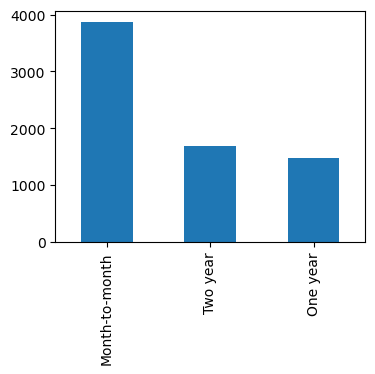

Distribution of classes of a categorical variable: paperless_billing


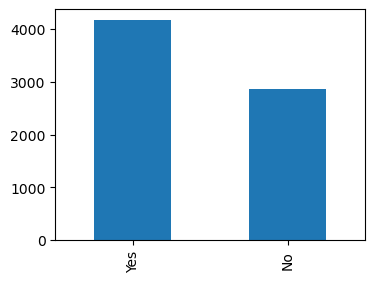

Distribution of classes of a categorical variable: payment_method


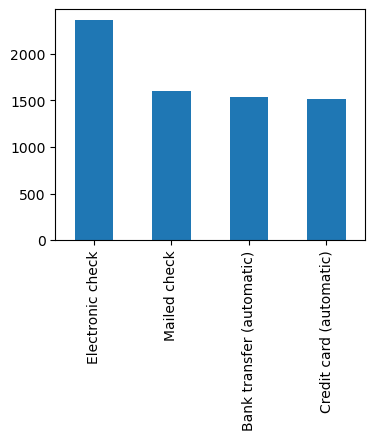

Distribution of classes of a categorical variable: senior_citizen


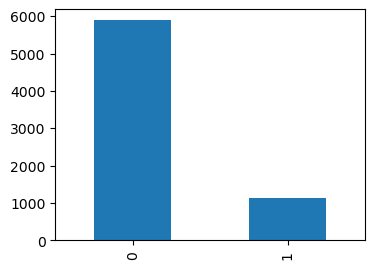

Distribution of classes of a categorical variable: partner


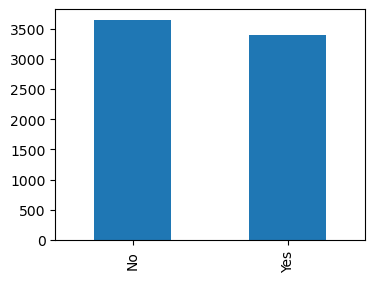

Distribution of classes of a categorical variable: dependents


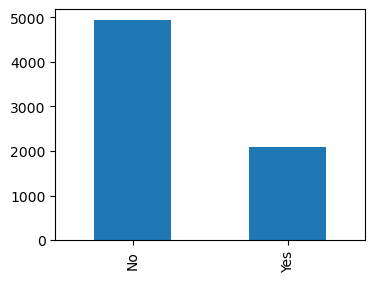

Distribution of classes of a categorical variable: multiple_lines


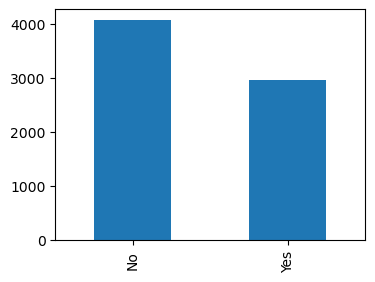

Distribution of classes of a categorical variable: phone


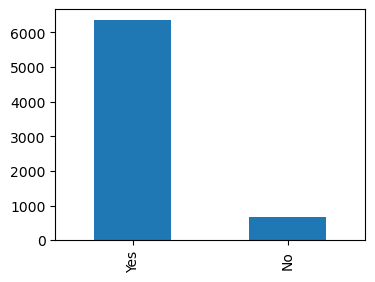

Distribution of classes of a categorical variable: internet_service


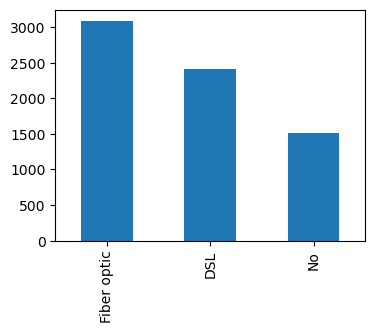

Distribution of classes of a categorical variable: online_security


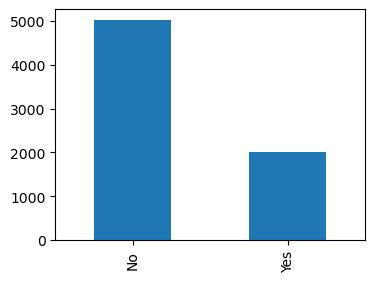

Distribution of classes of a categorical variable: online_backup


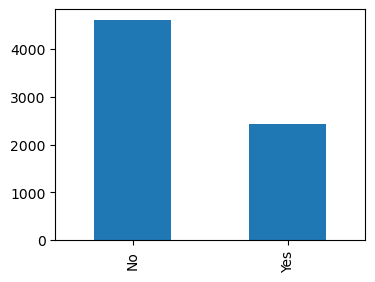

Distribution of classes of a categorical variable: device_protection


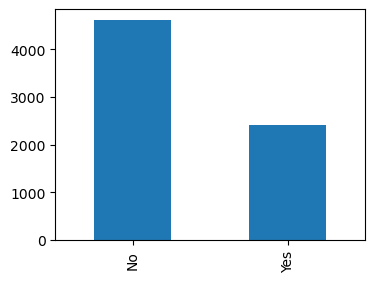

Distribution of classes of a categorical variable: tech_support


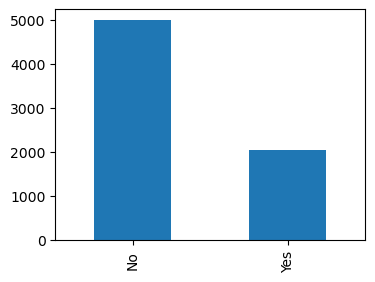

Distribution of classes of a categorical variable: streaming_tv


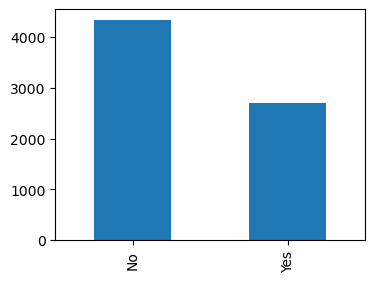

Distribution of classes of a categorical variable: streaming_movies


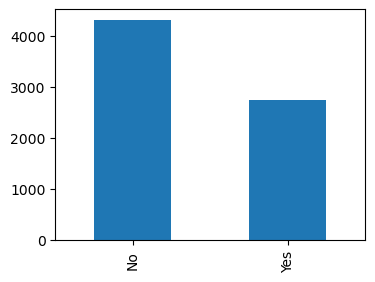

Distribution of classes of a categorical variable: is_gone


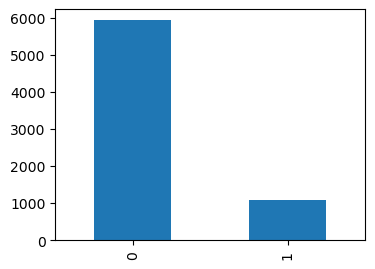

Distribution of classes of a categorical variable: int_or_phone


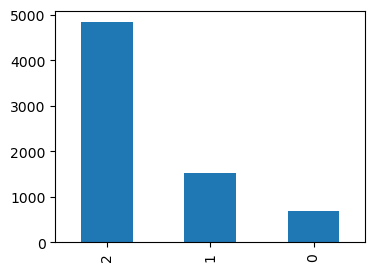

In [29]:
categorical_features = ['type', 'paperless_billing', 'payment_method',
       'senior_citizen', 'partner', 'dependents',
       'multiple_lines', 'phone', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'is_gone', 'int_or_phone']

for i in data[categorical_features]:
    print('Distribution of classes of a categorical variable:', i)
    data[i].value_counts().plot(kind='bar', figsize=(4,3))
    plt.show()

Analysis of the distribution of classes of categorical variables allows us to conclude that there are no outliers. At the same time, we can highlight the following most striking trends in the data:
- in most cases, users enter into a monthly contract;
- pensioners are about 6 times less than other customers;
- approximately equal number of users with and without a partner;
- there is a clear imbalance of classes in the target feature, about 6 times less users who have terminated the contract;
- the vast majority uses both the telephone and the Internet.

Now let's look at the distribution of values in numeric variables.

Basic statistical parameters for: monthly_charges
count    7032.00
mean       64.80
std        30.09
min        18.25
25%        35.59
50%        70.35
75%        89.86
max       118.75
Name: monthly_charges, dtype: float64

Boxplot and a histogram of the distribution of values for: monthly_charges


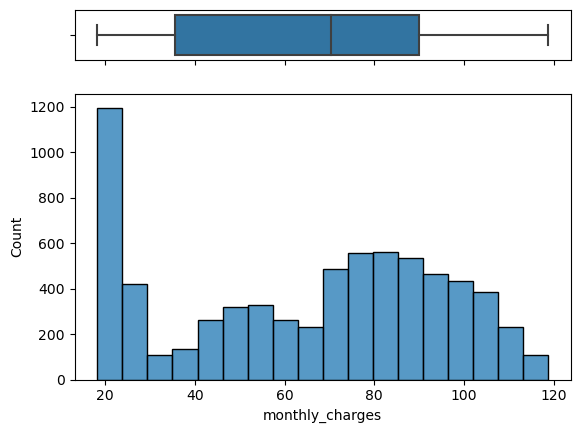

Basic statistical parameters for: total_charges
count    7032.00
mean     2118.62
std      2112.74
min        19.05
25%       439.74
50%      1345.28
75%      3239.32
max      9221.38
Name: total_charges, dtype: float64

Boxplot and a histogram of the distribution of values for: total_charges


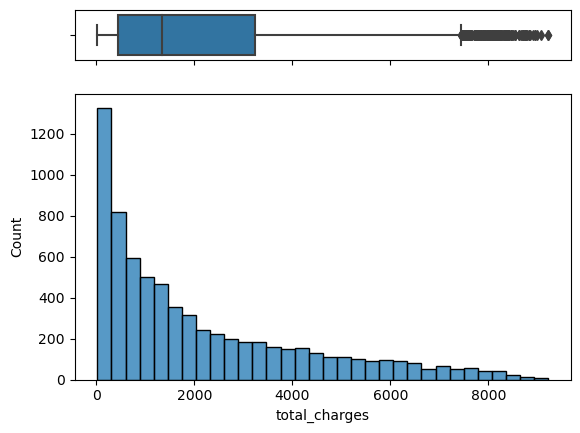

Basic statistical parameters for: days
count    7032.00
mean      899.96
std       682.74
min        28.00
25%       276.00
50%       761.00
75%      1461.00
max      2314.00
Name: days, dtype: float64

Boxplot and a histogram of the distribution of values for: days


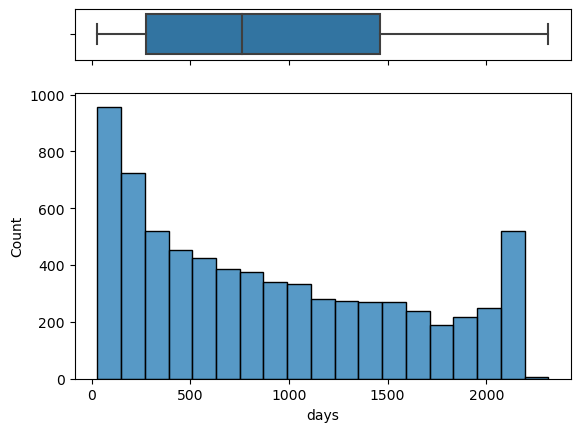

In [30]:
numerical_features = ['monthly_charges', 'total_charges', 'days']

for i in data[numerical_features]:
    print('Basic statistical parameters for:', i)
    print((data[i].describe().round(2)))
    print()
    print('Boxplot and a histogram of the distribution of values for:', i)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data[i], ax=ax_box)
    sns.histplot(data=data, x=i, ax=ax_hist)
    ax_box.set(xlabel='')
    plt.show()

The analysis of the values of numerical features allows us to highlight the following points:
- in all cases, the minimum and maximum values are trusted, the values are adequate;
- the median is close to 70 for monthly expenses. However, the mean is 64. This is due to the fact that on the histogram you can observe the mode near 20;
- the minimum value among the total expenses is 19. Most likely, this is due to the fact that the customers are either new or quickly terminated the contract in this case;
- we see that the distribution of the number of days in the client's status is most uniform compared to other variables. However, a value close to 100 and a value greater than 2000 can be distinguished here.

### <font color=#0000FF>Searching for dependencies in data</font>

First, let's create a Pearson correlation matrix for numerical data.

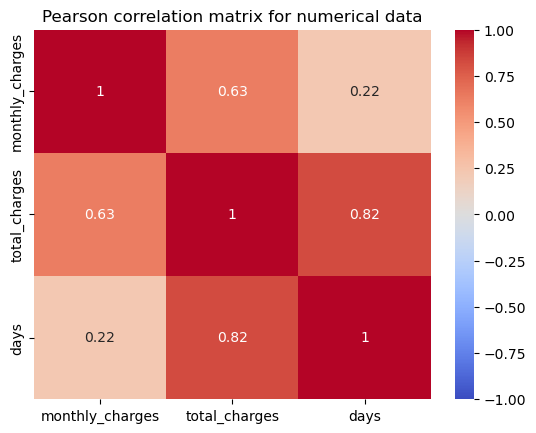

In [31]:
sns.heatmap(data[numerical_features].corr(), vmin=-1, vmax=1, annot=True, cmap= 'coolwarm')
plt.title('Pearson correlation matrix for numerical data')
plt.show()

The correlation matrix for numerical features and target feature allows us to conclude:
- the number of days in the client's status directly correlates with the total expenses, but it almost does not correlate with the expenses for the month;
- there is a good positive correlation between monthly expenses and total expenses.

Now let's create a correlation matrix for all the features using Phi_K correlation.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'is_gone', 'days', 'int_or_phone']


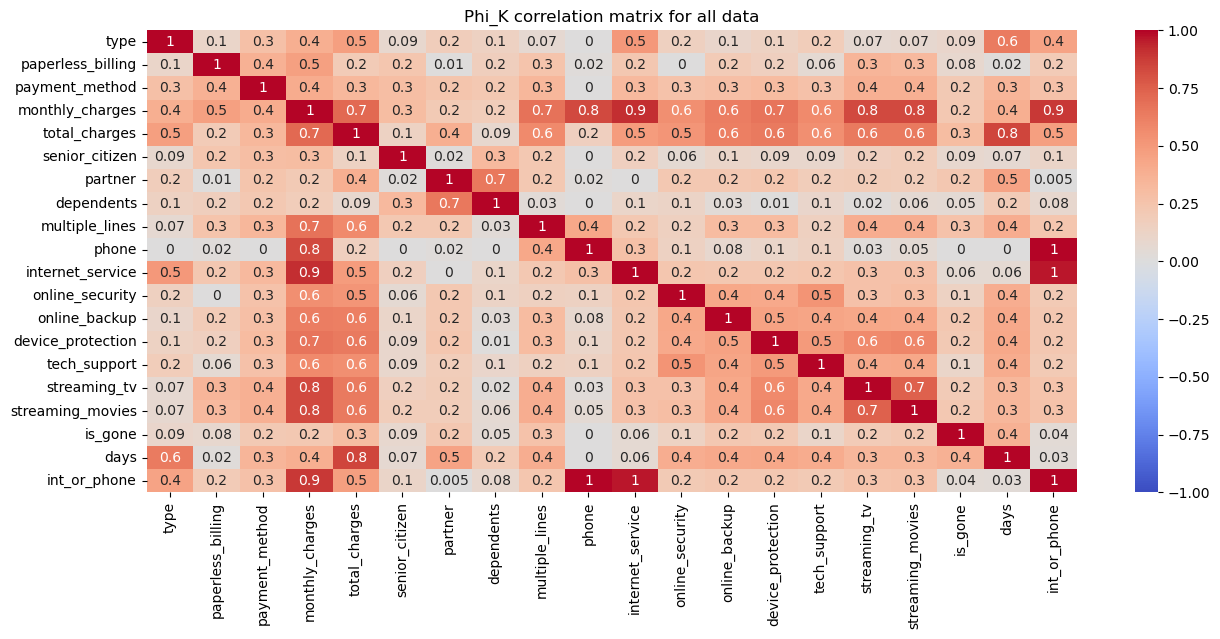

In [32]:
plt.figure(figsize=(15, 6))
sns.heatmap(data.phik_matrix(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', annot=True, fmt='.1g')
plt.title('Phi_K correlation matrix for all data')
plt.show()

Conclusions from the Phi_K correlation::
- the target feature has a slight direct correlation with the number of days in the client status, as well as with the total expenses; 
- a red square is noticeable almost in the center of the matrix. This indicates a very high correlation between all Internet services;
- the number of days in the client's status directly correlates with the total Internet expenses (logical), the periodicity of payment (interesting) and the existence of a partner (surprised).

Now let's plot the dependence of different variables on the target feature in order to understand the main trends.

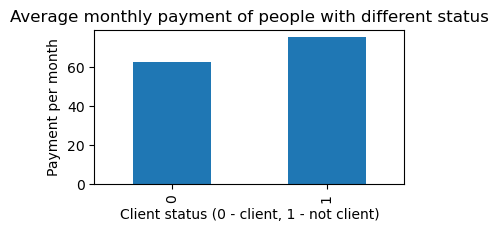

In [33]:
data.groupby('is_gone')['monthly_charges'].mean().plot(kind='bar', figsize=(4, 2))
plt.xlabel('Client status (0 - client, 1 - not client)')
plt.ylabel('Payment per month')
plt.title('Average monthly payment of people with different status')
plt.show()

We see that people who terminated the contract paid more on average per month. 

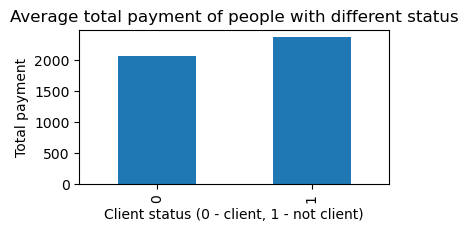

In [34]:
data.groupby('is_gone')['total_charges'].mean().plot(kind='bar', figsize=(4, 2))
plt.xlabel('Client status (0 - client, 1 - not client)')
plt.ylabel('Total payment')
plt.title('Average total payment of people with different status')
plt.show()

It turns out that the people who left paid more in total.

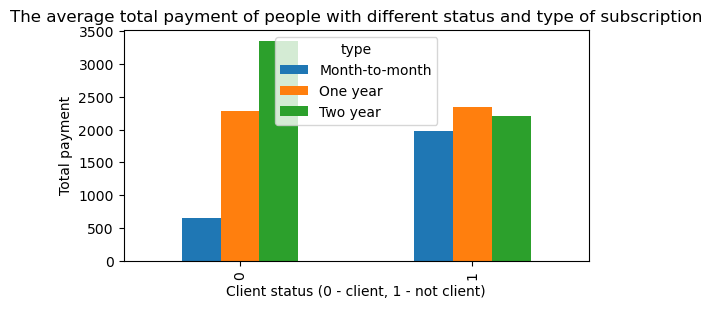

In [35]:
pd.pivot_table(data, index='is_gone', columns='type', 
               values='total_charges', aggfunc='median').plot(kind='bar', figsize=(6, 3))
plt.xlabel('Client status (0 - client, 1 - not client)')
plt.ylabel('Total payment')
plt.title('The average total payment of people with different status and type of subscription')
plt.show()

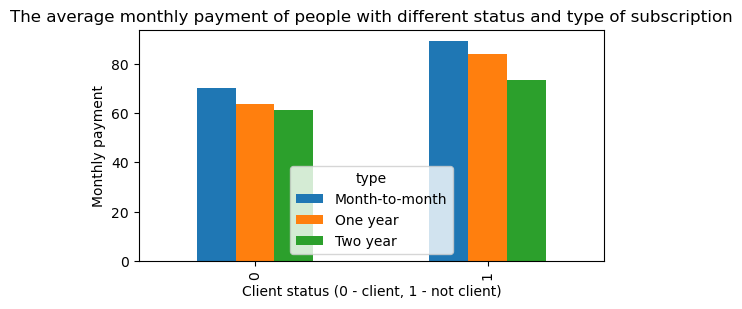

In [36]:
pd.pivot_table(data, index='is_gone', columns='type', 
               values='monthly_charges', aggfunc='median').plot(kind='bar', figsize=(6, 3))
plt.xlabel('Client status (0 - client, 1 - not client)')
plt.ylabel('Monthly payment')
plt.title('The average monthly payment of people with different status and type of subscription')
plt.show()

An interesting conclusion can be drawn. People who used a monthly subscription and who terminated the contract paid more on average. Let's look at the dependence of the number of people with different subscription types on the number of days in a client status.

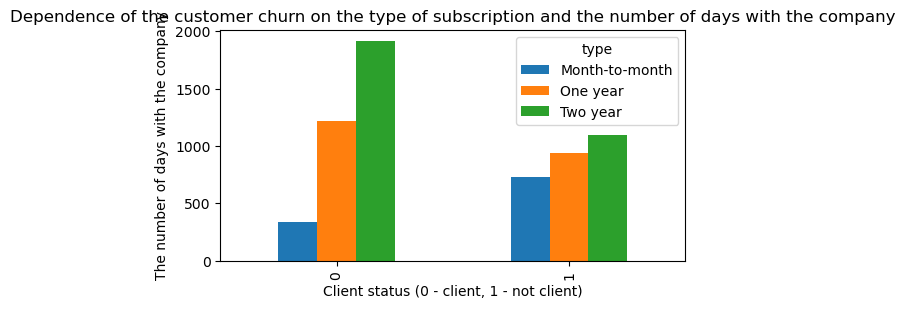

In [37]:
pd.pivot_table(data, index='is_gone', columns='type', 
               values='days', aggfunc='median').plot(kind='bar', figsize=(6, 3))
plt.xlabel('Client status (0 - client, 1 - not client)')
plt.ylabel('The number of days with the company')
plt.title('Dependence of the customer churn on the type of subscription and the number of days with the company')
plt.show()

The graph shows that customers who have a monthly subscription leave the company faster.

Now let's look at the general portrait of those who stop using the company's services.

In [38]:
is_gone_1 = data[data['is_gone']==1]
is_gone_0 = data[data['is_gone']==0]

def comparative_graphs(feature, title_1, title_0):
    is_gone_1[feature].value_counts().plot(kind='pie', figsize=(1.5, 1.5))
    plt.title(title_1)
    plt.show()
    is_gone_0[feature].value_counts().plot(kind='pie', figsize=(1.5, 1.5))
    plt.title(title_0)
    plt.show()

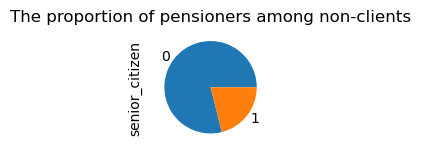

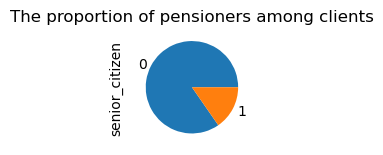

In [39]:
comparative_graphs('senior_citizen', 'The proportion of pensioners among non-clients',
                  'The proportion of pensioners among clients')

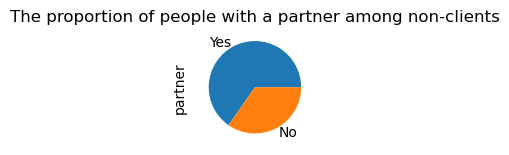

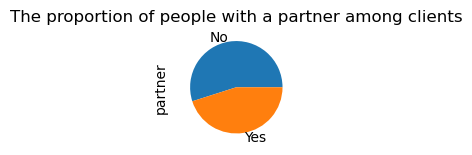

In [40]:
comparative_graphs('partner', 'The proportion of people with a partner among non-clients',
                  'The proportion of people with a partner among clients')

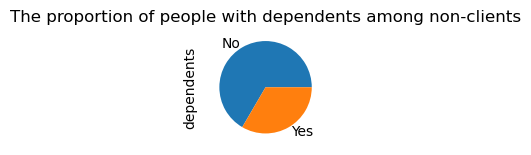

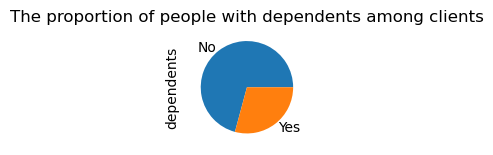

In [41]:
comparative_graphs('dependents', 'The proportion of people with dependents among non-clients',
                  'The proportion of people with dependents among clients')

It can be argued that among the people who terminated the contract, a large proportion of pensioners and single people.

Now let's see what services customers and non-customers used (internet only (0), phone only (1), phone + internet (2)).

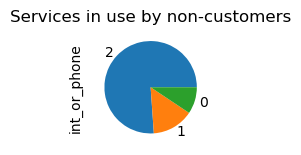

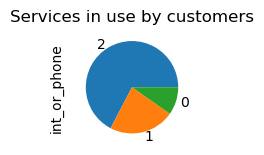

In [137]:
comparative_graphs('int_or_phone', 'Services in use by non-customers',
                  'Services in use by customers')

We see that people who left used both the phone and the Internet more often. Perhaps it was too expensive.

Conclusions after exploratory data analysis:
- there are no missing values or duplicates in the data;
- three additional features were created for further work (target feature - the fact of churn, the number of days of a person as a client, the availability of services to the user);
- non-informative features (gender, customer ID) and features that have played their role and are no longer needed (the beginning of the contract, the end of the contract) were removed;
- there are no outliers among the data, and the distributions of numerical values are adequate;
- there is a clear imbalance of classes in the target feature, about 6 times fewer users who terminated the contract;
- the target feature has a weak direct correlation with the number of days in the client status, as well as with the total spending; 
- the number of days of being a client directly correlates with the total Internet spending, payment periodicity, and the availability of a partner;
- the customers who left, in most cases, used a monthly subscription and paid the most per month and in total;
- customers left faster if they used monthly subscriptions;
- there is a large proportion of people without a partner and pensioners among the clients who left;
- the people who used both the phone and the Internet were the most likely to leave.

## <font color=#00008B>Searching for a machine learning model</font>

### <font color=#0000FF>Creating samples</font>

In [138]:
features = data.drop(columns=['is_gone'])
target = data['is_gone']

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, stratify = target)

In [139]:
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5274, 19) (1758, 19) (5274,) (1758,)


### <font color=#0000FF>Coding of categorical features</font>

In [140]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

print(ohe_features)

['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'multiple_lines', 'phone', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


Let's create a transformer. It is necessary to provide for the removal of the first feature from the encoded ones.

In [141]:
transformer = make_column_transformer((OneHotEncoder(drop='first'), 
                        ohe_features),
                        remainder='passthrough')

Let's start coding. 

In [142]:
transformed_train = transformer.fit_transform(features_train)
features_train = pd.DataFrame(transformed_train, columns=transformer.get_feature_names_out())

transformed_test = transformer.transform(features_test)
features_test = pd.DataFrame(transformed_test, columns=transformer.get_feature_names_out())

print('Encoded features for learning:', features_train.info())
print('Encoded features for test:', features_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5274 entries, 0 to 5273
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   onehotencoder__type_One year                           5274 non-null   float64
 1   onehotencoder__type_Two year                           5274 non-null   float64
 2   onehotencoder__paperless_billing_Yes                   5274 non-null   float64
 3   onehotencoder__payment_method_Credit card (automatic)  5274 non-null   float64
 4   onehotencoder__payment_method_Electronic check         5274 non-null   float64
 5   onehotencoder__payment_method_Mailed check             5274 non-null   float64
 6   onehotencoder__partner_Yes                             5274 non-null   float64
 7   onehotencoder__dependents_Yes                          5274 non-null   float64
 8   onehotencoder__multiple_lines_Yes               

Let's remove the unnecessary things from the column names.

In [143]:
features_train.columns  = ['type_One year', 'type_Two year',
       'paperless_billing_Yes',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check',
       'payment_method_Mailed check',
       'partner_Yes', 'dependents_Yes',
       'multiple_lines_Yes', 'phone_Yes',
       'internet_service_Fiber optic',
       'internet_service_No', 'online_security_Yes',
       'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes', 'monthly_charges',
       'total_charges', 'senior_citizen',
       'days', 'int_or_phone']

In [144]:
features_test.columns  = ['type_One year', 'type_Two year',
       'paperless_billing_Yes',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check',
       'payment_method_Mailed check',
       'partner_Yes', 'dependents_Yes',
       'multiple_lines_Yes', 'phone_Yes',
       'internet_service_Fiber optic',
       'internet_service_No', 'online_security_Yes',
       'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes', 'monthly_charges',
       'total_charges', 'senior_citizen',
       'days', 'int_or_phone']

### <font color=#0000FF>Scaling of numerical features</font>

In [145]:
scaler = StandardScaler()

scaler.fit(features_train[numerical_features])

features_train[numerical_features] = scaler.transform(features_train[numerical_features])

features_test[numerical_features] = scaler.transform(features_test[numerical_features])

We will search for the best models with GridSearchCV. Let's set 5 blocks for cross-validation and the metric AUC-ROC. Let me remind that AUC-ROC must be greater than 0.85.

We will look for the best model among RandomForestClassifier, LogisticRegression, and LightGBM.

### <font color=#0000FF>RandomForestClassifier</font>

I included the 'class_weight' parameter in this model to evaluate how the model learns with class imbalance.

In [146]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)

parameters_forest = { 
    'n_estimators': [100, 150, 200],
    'max_depth' : [2, 5, 10, 20, 25, 30],
    'class_weight': ['balanced', None]
}
    
grid_search_forest = GridSearchCV(estimator=forest, param_grid=parameters_forest, 
                                      scoring='roc_auc', cv=5, n_jobs=-1)
    
grid_search_forest.fit(features_train, target_train)

# then make a table with learning time, prediction time, metrics, and best parameters

forest_best = grid_search_forest.best_params_
                                                
forest_table = pd.DataFrame(grid_search_forest.cv_results_)

forest_table = forest_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

forest_table = forest_table[forest_table['params']==forest_best]

forest_table = forest_table.rename(columns={ 
    'mean_fit_time':'Learning time (с)', 
    'mean_score_time':'Prediction time (с)',
    'params':'Parameters',
    'mean_test_score':'AUC-ROC'
})

print('Parameters for the best model of RandomForestClassifier:')
print()
forest_table

Parameters for the best model of RandomForestClassifier:



,Learning time (с),Prediction time (с),Parameters,AUC-ROC
25,0.491669,0.02689,"{'class_weight': None, 'max_depth': 10, 'n_est...",0.826985


### <font color=#0000FF>LogisticRegression</font>

Here I also provided for the possibility of learning the model, considering the imbalance of classes.

In [147]:
log = LogisticRegression(random_state=RANDOM_STATE)

parameters_log = { 
    'C': [0.5, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter' : [100, 1000],
    'class_weight': ['balanced', None]
}
    
grid_search_log = GridSearchCV(estimator=log, param_grid=parameters_log, 
                                   scoring='roc_auc', cv=5, n_jobs=-1)
    
grid_search_log.fit(features_train, target_train)

log_best = grid_search_log.best_params_

log_table = pd.DataFrame(grid_search_log.cv_results_)

log_table = log_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

log_table = log_table[log_table['params']==log_best]

log_table = log_table.rename(columns={ 
    'mean_fit_time':'Learning time (с)', 
    'mean_score_time':'Prediction time (с)',
    'params':'Parameters',
    'mean_test_score':'AUC-ROC'
})

print('Parameters for the model of LogisticRegression:')
print()
log_table

Parameters for the model of LogisticRegression:



,Learning time (с),Prediction time (с),Parameters,AUC-ROC
17,0.146769,0.001736,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.777886


### <font color=#0000FF>LightGBM</font>

As in previous cases, in LightGBM models, I set the parameters search with and without class imbalance ('is_unbalance').

In [148]:
lgbm = lgb.LGBMClassifier(random_state = RANDOM_STATE, objective='binary')

parameters_lgbm = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 5, 10, 20],
    'num_leaves': [5, 15, 20, 30, 50],
    'num_iterations': [200, 500, 1000],
    'is_unbalance': [True, False]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=parameters_lgbm, 
                                scoring='roc_auc', cv=5, n_jobs=-1)

grid_search_lgbm.fit(features_train, target_train)

lgbm_best = grid_search_lgbm.best_params_

lgbm_table = pd.DataFrame(grid_search_lgbm.cv_results_)

lgbm_table = lgbm_table[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]

lgbm_table = lgbm_table[lgbm_table['params']==lgbm_best]

lgbm_table = lgbm_table.rename(columns={ 
    'mean_fit_time':'Learning time (с)', 
    'mean_score_time':'Prediction time (с)',
    'params':'Parameters',
    'mean_test_score':'AUC-ROC'
})

print('Parameters for the best model of LightGBM:')
print()
lgbm_table

Parameters for the best model of LightGBM:



,Learning time (с),Prediction time (с),Parameters,AUC-ROC
190,0.234535,0.023071,"{'is_unbalance': False, 'learning_rate': 0.1, ...",0.903869


Now let's compare the three resulting tables.

In [149]:
print('RandomForestClassifier')
forest_table

RandomForestClassifier


,Learning time (с),Prediction time (с),Parameters,AUC-ROC
25,0.491669,0.02689,"{'class_weight': None, 'max_depth': 10, 'n_est...",0.826985


In [150]:
print('LogisticRegression')
log_table

LogisticRegression


,Learning time (с),Prediction time (с),Parameters,AUC-ROC
17,0.146769,0.001736,"{'C': 1, 'class_weight': 'balanced', 'max_iter...",0.777886


In [151]:
print('LightGBM')
lgbm_table

LightGBM


,Learning time (с),Prediction time (с),Parameters,AUC-ROC
190,0.234535,0.023071,"{'is_unbalance': False, 'learning_rate': 0.1, ...",0.903869


We can see that the gradient-busting model (LightGBM) shows the best results on the training dataset during cross-validation. The metric is equal to 0.90. The best parameters of this model are: 

'is_unbalance': False,

'learning_rate': 0.1,

'max_depth': 2,

'num_iterations': 1000,

'num_leaves': 5. 

We can start testing it.

## <font color=#00008B>Testing the best machine learning model</font>

The AUC-ROC value for the LightGBM model on the test: 0.901


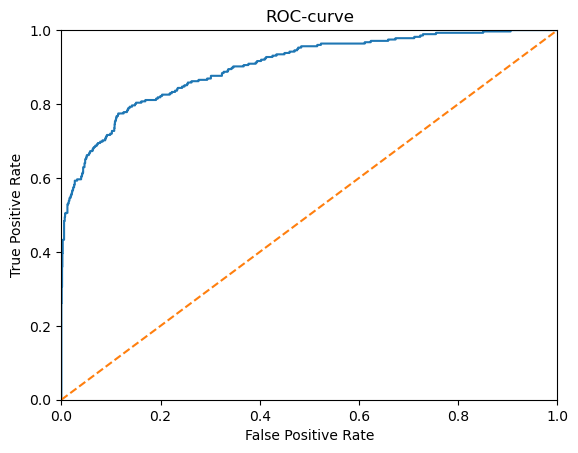

In [152]:
predicted_test = grid_search_lgbm.predict(features_test)

probabilities_test = grid_search_lgbm.predict_proba(features_test)

probabilities_one_test = probabilities_test[:, 1]

print('The AUC-ROC value for the LightGBM model on the test:', \
      (roc_auc_score(target_test, probabilities_one_test)).round(3))

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

Our model did well, the AUC-ROC on the test is 0.901.

Let's look at the importance of the features of the best model.

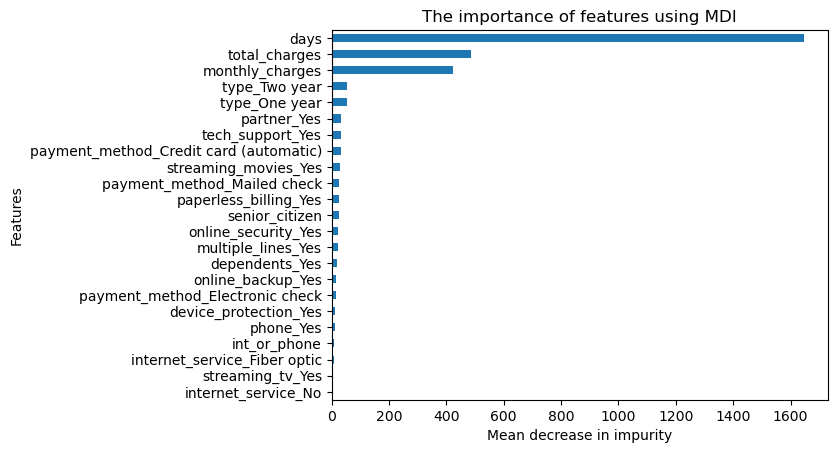

In [153]:
features_names = features_train.columns.to_list()

importances = grid_search_lgbm.best_estimator_.feature_importances_

lgbm_importances = pd.Series(importances, index=features_names).sort_values()

lgbm_importances.plot(kind='barh')

plt.title('The importance of features using MDI')

plt.xlabel('Mean decrease in impurity')

plt.ylabel('Features')

plt.show()

We see that the most important features are the number of days with the company and spending on services.

To see what answers the model gave, let's create an error matrix. 

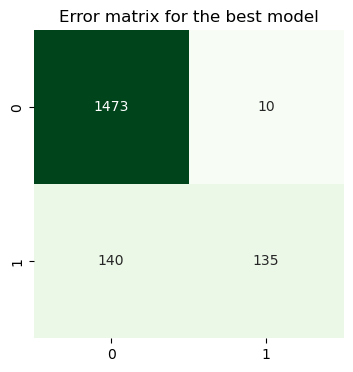

In [154]:
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_matrix(target_test, predicted_test), annot=True, cmap= 'Greens', cbar=False, fmt='d')
plt.title('Error matrix for the best model')
plt.show()

Let's see what results the constant model produces.

In [155]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(features_train, target_train)
dummy_predict = dummy.predict(features_test)
print('AUC-ROC for the constant model', (roc_auc_score(target_test, dummy_predict)).round(2))

AUC-ROC for the constant model 0.5


We see how low the metric of the constant model is. Our model is adequate.

## <font color=#00008B> Final report</font>

### <font color=#0000FF>The initial task</font>

I was tasked with developing a machine-learning model for a telecom operator "Ниединогоразрыва.ком" capable of predicting customer churn. This is essential for a telecom operator because, on the basis of such data, it is possible to develop strategies that will help retain customers and increase profits.

### <font color=#0000FF>Used metrics</font>

We are faced with the task of reducing the company's losses, which is minimizing the actions that include:
- the client does not leave, but we offer him bonuses (FALSE POSITIVE);
- the client left, but we didn't offer him anything (FALSE NEGATIVE).


Taking the above into account, the **metric AUC-ROC** was used. Its target value in the test sample should be **0.85**, but higher values were also welcome.

### <font color=#0000FF>Used data</font>

**The operator team gave me the following data**, which is current as of February 1, 2020.

**contract - data on contracts**

customerID - customer identifier;

BeginDate - start date of using services;

EndDate - date of termination of use of services;

Type - payment type (monthly, annual, etc.);

Paperlessbilling - electronic payment document;

PaymentMethod - payment method;

MonthlyCharges - monthly spending on services;

TotalCharges - total money spent on services.

**personal - personal data of customers**

gender - sex;

SeniorCitizen - seniority status;

Partner - having a spouse;

Dependents - having dependents.

**internet - data on internet services**

InternetService - type of connection (DSL/Fiber optic);

OnlineSecurity - availability of a service for blocking unsafe sites;

OnlineBackup - availability of cloud storage for data backup;

DeviceProtection - antivirus service;

TechSupport - a dedicated technical support line;

StreamingTV - availability of streaming TV service;

StreamingMovies - movie catalog service.

**internet - data on telephony services**

MultipleLines - possibility of running parallel lines during a call.

It should be noted that **the data provided by the company are of high quality**. No duplicates or missing values were found in them. This greatly facilitated data processing.

### <font color=#0000FF>Exploratory data analysis (EDA)</font>

Efforts were made to characterize the adequacy of the values of certain features, establish the character of data distribution, to identify patterns of dependence of data and their correlation with each other. 

**Main results of EDA**:
- there are no outliers among the categorical data, and the distributions of numerical values are adequate;
- there is a clear imbalance of classes in the target feature;
- the target attribute has a weak direct correlation with the number of days in client status, as well as with the total spending; 
- the number of client days directly correlates with the total spending, payment periodicity and the existence of a partner;
- the customers who left, in most cases, used a monthly subscription and paid the most per month and in total;
- customers left faster if they used the monthly subscription.

### <font color=#0000FF>Results from a search for machine learning models. Testing the best model</font>

Three models were considered:
- RandomForestClassifier;
- LogisticRegression;
- LightGBM.

Using automatic hyperparameter selection and cross validation (GridSearchCV), the **best model was found to be LightGBM. The AUC-ROC on cross-validation was 0.90**.

**Parameters of the best LightGBM model**:
- random_state = 240423
- objective='binary'
- is_unbalance=False
- learning_rate=0.1
- max_depth=2
- num_iterations=1000
- num_leaves=5.


The AUC-ROC was 0.90 on the test. Success. The model also successfully passed the test for adequacy using a constant model (DummyClassifier).

The analysis of the importance of the features showed that the greatest contribution in determining the target feature is made by such features:

- number of client days with the company:
- number of monthly spending;
- number of total spending.

This conclusion is consistent with the fact that the EDA stage revealed the highest correlation between these features and the target feature.

## <font color=#00008B> Main conclusion </font>

Thus, the LightGBM model with the above parameters will be offered to the "Ниединогоразрыва.ком" telecom operator for predicting customer churn. It does an excellent job, demonstrating AUC-ROC=0.90.